#  Tutorial 8: SBM and DC-SBM

 <font color='magneta'> In this tutorial, we will implement various inference techniques and models to solve the SBM on real networks. We will use several codes developed in the package pysbm. </font>

# Exercise 1

### Exercise 1.a

* Clone the github repository pysbm at https://github.com/funket/pysbm.

### Exercise 1.b

* Download the datasets of American College football *(football)*, Zachary’s karate club *(karate)* and Political blogs *(polblogs)* from http://www-personal.umich.edu/~mejn/netdata/ and put them inside the folder pysbm/Network Data/.

Now, we need to import the `pysbm` package and the `networkx` package, 
which is the used package for representing the networks. 
Additionally, we want to handle ```numpy``` structures and create some plots with `matplotlib`. 

If you later want to process larger graphs, we recommend using [PyPy](https://pypy.org). 


In [3]:
# Import libraries
import pysbm
import numpy as np
import networkx as nx
import matplotlib.pylab as plt

In [4]:
dataset = {'karate':'./pysbm/Network Data/karate/karate.gml',
           'football':'./pysbm/Network Data/football/football.gml',
           'polblogs':'./pysbm/Network Data/polblogs/polblogs.gml'}

In [5]:
colors = {0:'b',1:'r',2:'g',3:'orange',4:'black',5:'magenta'}

We start with one of the standard examples, the karate club network.

* Import dataset into a `networkx` network object. Make it `undirected` as we are interested in studying, for simplicity, only this version.   
Keep only the largest connected component.

In [7]:
# Step 1: import the dataset
dname = 'karate'
if dname=='karate':
    graph = nx.read_gml(dataset[dname], label = 'id')
else:
    graph = nx.read_gml(dataset[dname])
    
graph = graph.to_undirected()

Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
graph = graph.subgraph(Gcc[0])
print(graph.nodes())
print('N =',graph.number_of_nodes(),' E =',graph.number_of_edges())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
N = 34  E = 78


**Goal**: replicate the example of Karrer and Newmann 2011 
(https://journals.aps.org/pre/pdf/10.1103/PhysRevE.83.016107)

Let's infer stochastic block models for the karate club graph with the standard  SBM. First, we need the graph and encapsulate the graph into a `partition` object with the known number of blocks.

In [9]:
K = 2
standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=False)

Now we take a look at the current state and plot the nodes with size proportional to their degree and with color equivalent to the group they belong to.

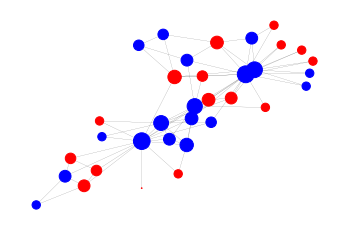

In [10]:
node_size = [np.log(graph.degree[i])*100+0.5 for i in list(graph.nodes())]
position = nx.spring_layout(graph,iterations=200)

plt.figure()
nx.draw_networkx_nodes(graph, position, node_size=node_size,
                       node_color=[colors[standard_partition.get_block_of_node(node)] for node in graph])
nx.draw_networkx_edges(graph,pos=position,width=0.1)
plt.axis('off')
plt.show()

### Exercise 1.c

We now run 3 different inference methods:
   * `KarrerInference`: the greedy with MC moves proposed by Karrer & Newman to find the maximum of the objective function.
   * `MetropolisHastingInference`: a Metropolis Hasting MC scheme similar to Karrer & Newman but where there is an acceptance rate to a move. The Karrer & Newman instead, makes deterministic moves that always improve the objective function. 
   * `PeixotoInference`: a Metropolis Hasting MC scheme wich aggregates blocks, in addition to switching single nodes' groups. This is similar to `MetropolisHastingInference` but in addition merges blocks while performing moves.

All the three methods will end up in a local minimum of the objective function. Therefore we run the inference 10 times and keep the partition associated to the best value of the objective function.

### **Inference 1**: `KarrerInference`

In [11]:
N_real=10
best_objective=-1000000
best_partition_standard=None
for r in range(N_real):
    standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
    standard_inference = pysbm.KarrerInference(graph, standard_objective_function, standard_partition)
    standard_inference.infer_stochastic_block_model()
    L=standard_objective_function.calculate(standard_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard=standard_partition
    print(r,L,best_objective)

0 -244.08606091088618 -244.08606091088618
1 -233.52608348059132 -233.52608348059132
2 -233.52608348059132 -233.52608348059132
3 -233.5260834805913 -233.5260834805913
4 -233.52608348059132 -233.5260834805913
5 -245.2788552328234 -233.5260834805913
6 -233.5260834805913 -233.5260834805913
7 -239.4521718457837 -233.5260834805913
8 -233.5260834805913 -233.5260834805913
9 -244.08606091088618 -233.5260834805913


### **Inference 1b**: `KarrerInference` with no negative moves allowed.

In [12]:
N_real=10
best_objective=-1000000
best_partition_standard_nn=None
for r in range(N_real):
    standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
    standard_inference = pysbm.KarrerInferenceNoNegativeMove(graph, standard_objective_function, standard_partition)
    standard_inference.infer_stochastic_block_model()
    L=standard_objective_function.calculate(standard_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard_nn=standard_partition
    print(r,L,best_objective)

0 -283.00124507766907 -283.00124507766907
1 -238.58546355646743 -238.58546355646743
2 -259.6695544199367 -238.58546355646743
3 -300.6320963369302 -238.58546355646743
4 -268.8439348990533 -238.58546355646743
5 -257.17582121703515 -238.58546355646743
6 -291.0901326070003 -238.58546355646743
7 -237.9102559676934 -237.9102559676934
8 -285.65915968805336 -237.9102559676934
9 -307.84680410088083 -237.9102559676934


### **Inference 2**: `MetropolisHastingInference` 

In [13]:
N_real=10
best_objective=-1000000
best_partition_standard_MH=None
for r in range(N_real):
    standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
    standard_inference = pysbm.MetropolisHastingInference(graph, standard_objective_function, standard_partition)
    standard_inference.infer_stochastic_block_model()
    L=standard_objective_function.calculate(standard_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard_MH=standard_partition
    print(r,L,best_objective)

0 -239.4521718457837 -239.4521718457837
1 -241.47320646262085 -239.4521718457837
2 -233.5260834805913 -233.5260834805913
3 -233.5260834805913 -233.5260834805913
4 -233.5260834805913 -233.5260834805913
5 -264.057813581708 -233.5260834805913
6 -238.58546355646743 -233.5260834805913
7 -233.5260834805913 -233.5260834805913
8 -233.52608348059132 -233.5260834805913
9 -245.66230888877084 -233.5260834805913


### **Inference 3**: `PeixotoInference` 

In [14]:
N_real=10
best_objective=-1000000
best_partition_standard_Peixoto=None
for r in range(N_real):
    standard_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
    standard_inference = pysbm.PeixotoInference(graph, standard_objective_function, standard_partition)
    standard_inference.infer_stochastic_block_model()
    L=standard_objective_function.calculate(standard_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard_Peixoto=standard_partition
    print(r,L,best_objective)

0 -245.6959760591511 -245.6959760591511
1 -233.52608348059132 -233.52608348059132
2 -233.52608348059132 -233.52608348059132
3 -251.92854532632964 -233.52608348059132
4 -233.5260834805913 -233.5260834805913
5 -233.52608348059132 -233.5260834805913
6 -233.52608348059132 -233.5260834805913
7 -233.52608348059132 -233.5260834805913
8 -233.52608348059132 -233.5260834805913
9 -233.52608348059132 -233.5260834805913


#### Plots the results

In [15]:
def node_colors(colors, partition, graph):
    node_colors = node_color=[colors[partition.get_block_of_node(node)] for node in graph]
    
    return node_colors

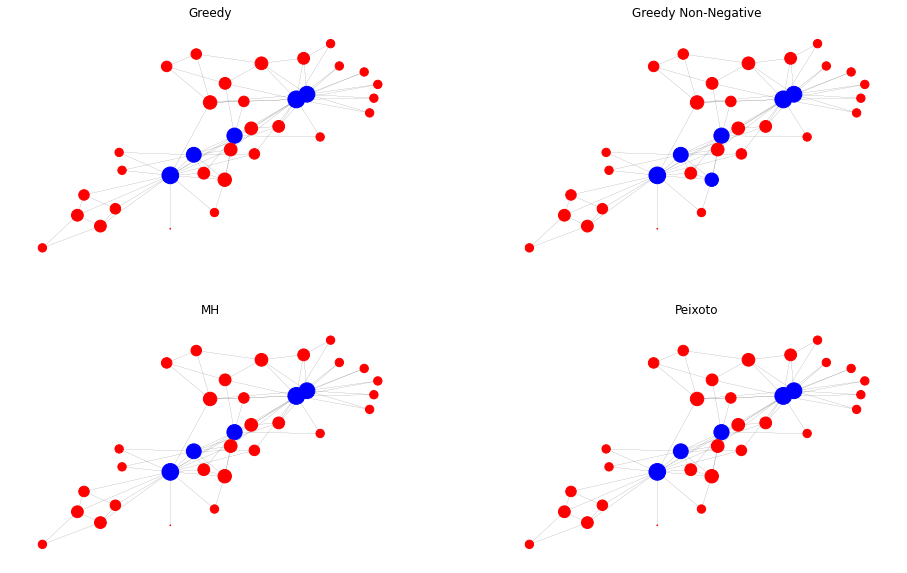

In [16]:
models = [best_partition_standard, best_partition_standard_nn, best_partition_standard_MH, best_partition_standard_Peixoto]
labels = ['Greedy', 'Greedy Non-Negative', 'MH', 'Peixoto']
plt.figure(figsize=(16,10))
for i, p in enumerate(models):
    plt.subplot(2,2,i+1)
    nx.draw_networkx_nodes(graph, position, node_size=node_size, node_color=node_colors(colors, p, graph))
    nx.draw_networkx_edges(graph,pos=position,width=0.1)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

### Exercise 1.d

* Plot the adjacency matrix ordered by blocks and compare it with the unordered one.

In [13]:
def find_groups(partition,graph,K=None):
    if K is None:
        K=partition.B
    groups=[[] for i in range(K)]
    for node in graph:
        q=partition.get_block_of_node(node)
        groups[q].append(node)
    return groups

def ordered_nodelist(partition,graph,K=None):
    groups=find_groups(partition,graph,K=K)
    K=len(groups)
    ordered_nodelist=sum(groups, []) # concatenate groups
    return ordered_nodelist

Random-order adjacency matrix


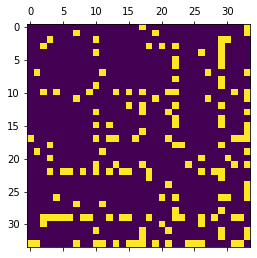

In [14]:
print('Random-order adjacency matrix')
plt.matshow(nx.to_numpy_matrix(graph,nodelist=np.random.permutation(list(graph.nodes()))))
plt.show()

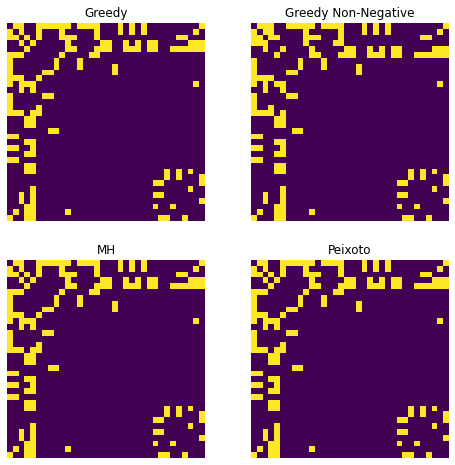

In [15]:
plt.figure(figsize=(8,8))
for i, p in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.imshow(nx.to_numpy_matrix(graph, nodelist=ordered_nodelist(p,graph,K=K)))
    plt.title(labels[i])
    plt.axis('off')
plt.show()

### Exercise 1.e

* Plot the affinity matrices of two partition at your choice.

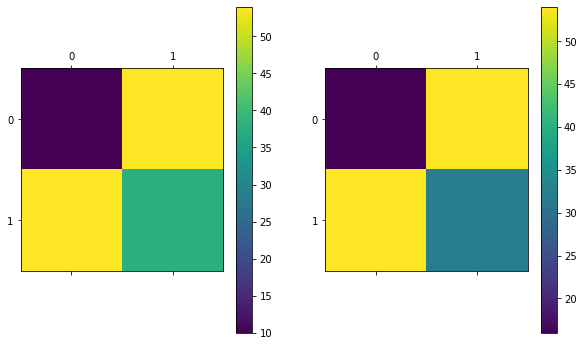

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
im1=ax1.matshow(best_partition_standard.block_edges)
im2=ax2.matshow(best_partition_standard_nn.block_edges)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

# Exercise 2

### Degree-corrected SBM

As you could notice, the best partition found by the algorithms favor a block division correlated with degree.   The solution to this problem is to incorporate explicitly degree heterogeneity into the model. 

This implies introducing new hidden variables $\theta_{i}\in \mathbb{R}\geq 0$ controlling the expected degree of node $i$.

\begin{eqnarray}
P(\mathbf{A}| q, C, \theta)&=& \prod_{i<j} \text{Pois} \,(A_{ij};\theta_{i}\theta_{j}\,C_{q_i q_j} ) \\
&=& \prod_{i<j} \frac{e^{-\theta_{i}\theta_{j}\,C_{q_iq_j}}\, (\theta_{i}\theta_{j}\,C_{q_iq_j})^{A_{ij}}}{A_{ij}!} \quad.
\end{eqnarray}

In [17]:
degree_corrected_objective_function = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False)

### Exercise 2.b

* Run the three previous inference methods, but this time using the degree-corrected likelihood as objective function.

### **Inference 1**: `KarrerInference`

In [18]:
N_real=10
best_objective=-1000000
best_partition_standard_DC=None
for r in range(N_real):
    degree_corrected_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)
    degree_corrected_inference = pysbm.KarrerInference(graph, degree_corrected_objective_function, degree_corrected_partition)
    degree_corrected_inference.infer_stochastic_block_model()
    L=degree_corrected_objective_function.calculate(degree_corrected_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard_DC=degree_corrected_partition
    print(r,L,best_objective)

0 -760.5686336551713 -760.5686336551713
1 -759.7255018557855 -759.7255018557855
2 -776.3822522617472 -759.7255018557855
3 -761.4465363512236 -759.7255018557855
4 -758.5076275895349 -758.5076275895349
5 -752.8516063587473 -752.8516063587473
6 -755.6306982856356 -752.8516063587473
7 -772.422917134498 -752.8516063587473
8 -739.3884041633212 -739.3884041633212
9 -759.7255018557855 -739.3884041633212


### **Inference 1b**: `KarrerInference` with no negative moves allowed.

In [19]:
N_real=10
best_objective=-1000000
best_partition_standard_nn_DC=None
for r in range(N_real):
    degree_corrected_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)#pysbm.NxPartition(graph=graph, number_of_blocks=K,representation=degree_corrected_partition.get_representation())
    degree_corrected_inference = pysbm.KarrerInferenceNoNegativeMove(graph, degree_corrected_objective_function, degree_corrected_partition)
    degree_corrected_inference.infer_stochastic_block_model()
    L=degree_corrected_objective_function.calculate(degree_corrected_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard_nn_DC=degree_corrected_partition
    print(r,L,best_objective)

0 -777.1065030401 -777.1065030401
1 -781.8450723516639 -777.1065030401
2 -782.893238865459 -777.1065030401
3 -782.1900471279994 -777.1065030401
4 -762.5852126465321 -762.5852126465321
5 -781.536308401726 -762.5852126465321
6 -766.6806885949176 -762.5852126465321
7 -778.0985799554472 -762.5852126465321
8 -778.3785585796779 -762.5852126465321
9 -782.893238865459 -762.5852126465321


### **Inference 2**: `MetropolisHastingInference` 

In [20]:
N_real=10
best_objective=-1000000
best_partition_standard_MH_DC=None
for r in range(N_real):
    degree_corrected_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)#pysbm.NxPartition(graph=graph, number_of_blocks=K,representation=degree_corrected_partition.get_representation())
    degree_corrected_inference = pysbm.MetropolisHastingInference(graph, degree_corrected_objective_function, degree_corrected_partition)
    degree_corrected_inference.infer_stochastic_block_model()
    L=degree_corrected_objective_function.calculate(degree_corrected_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard_MH_DC=degree_corrected_partition
    print(r,L,best_objective)

0 -752.8516063587473 -752.8516063587473
1 -769.2386684777092 -752.8516063587473
2 -752.8516063587473 -752.8516063587473
3 -752.8516063587473 -752.8516063587473
4 -756.1368401634361 -752.8516063587473
5 -757.6768053864125 -752.8516063587473
6 -739.4321474942633 -739.4321474942633
7 -764.4796759631556 -739.4321474942633
8 -760.4572073514587 -739.4321474942633
9 -763.2293932705899 -739.4321474942633


### **Inference 3**: `PeixotoInference` 

In [21]:
N_real=10
best_objective=-1000000
best_partition_standard_Peixoto_DC=None
for r in range(N_real):
    degree_corrected_partition = pysbm.NxPartition(graph=graph,number_of_blocks=K)#pysbm.NxPartition(graph=graph, number_of_blocks=K,representation=degree_corrected_partition.get_representation())
    degree_corrected_inference = pysbm.PeixotoInference(graph, degree_corrected_objective_function, degree_corrected_partition)
    degree_corrected_inference.infer_stochastic_block_model()
    L=degree_corrected_objective_function.calculate(degree_corrected_partition)
    if L>best_objective:
        best_objective=L
        best_partition_standard_Peixoto_DC=degree_corrected_partition
    print(r,L,best_objective)

0 -739.3884041633212 -739.3884041633212
1 -739.3884041633212 -739.3884041633212
2 -739.3884041633212 -739.3884041633212
3 -739.3884041633212 -739.3884041633212
4 -739.3884041633212 -739.3884041633212
5 -739.3884041633212 -739.3884041633212
6 -739.3884041633212 -739.3884041633212
7 -739.3884041633212 -739.3884041633212
8 -739.3884041633212 -739.3884041633212
9 -739.4321474942633 -739.3884041633212


#### Plots the results

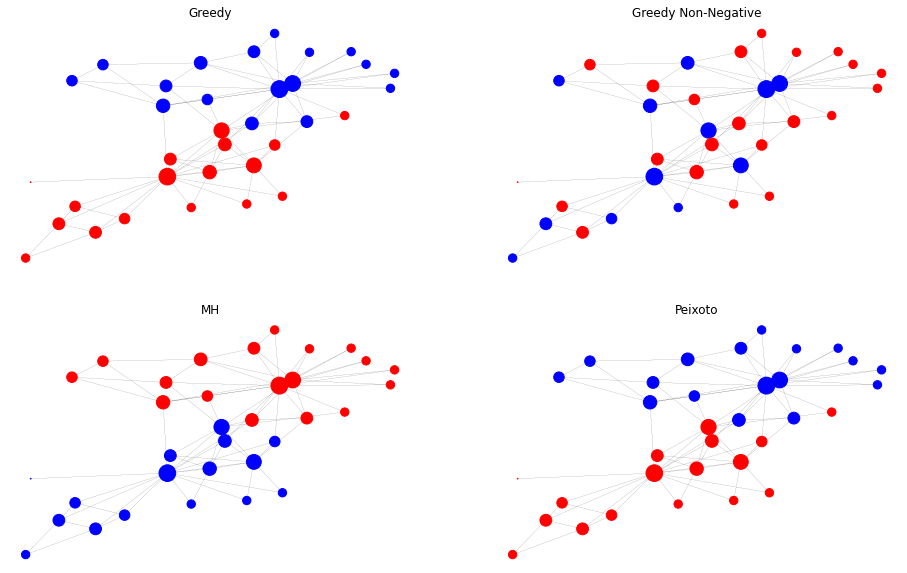

In [22]:
models_DC = [best_partition_standard_DC, best_partition_standard_nn_DC, best_partition_standard_MH_DC, best_partition_standard_Peixoto_DC]
plt.figure(figsize=(16,10))
for i, p in enumerate(models_DC):
    plt.subplot(2,2,i+1)
    nx.draw_networkx_nodes(graph, position, node_size=node_size, node_color=node_colors(colors, p, graph))
    nx.draw_networkx_edges(graph,pos=position,width=0.1)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

#### Plots the adjacency matrix ordered by blocks.

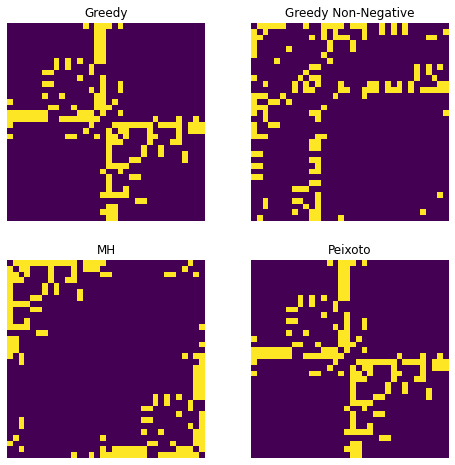

In [23]:
plt.figure(figsize=(8,8))
for i, p in enumerate(models_DC):
    plt.subplot(2,2,i+1)
    plt.imshow(nx.to_numpy_matrix(graph, nodelist=ordered_nodelist(p,graph,K=K)))
    plt.title(labels[i])
    plt.axis('off')
plt.show()

#### Plots the affinity matrices of two partition at your choice.

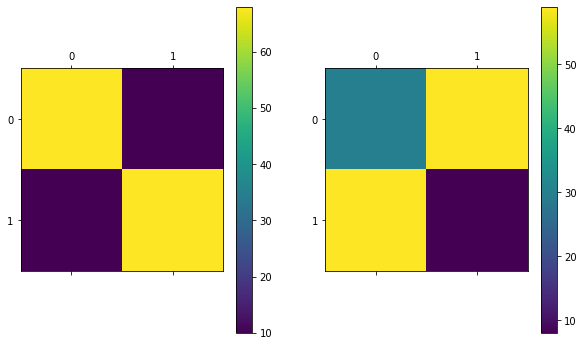

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
im1=ax1.matshow(best_partition_standard_DC.block_edges)
im2=ax2.matshow(best_partition_standard_nn_DC.block_edges)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

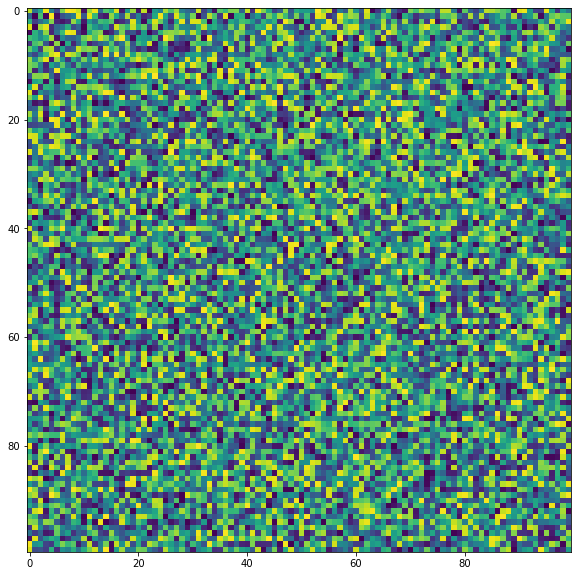

In [7]:
data = np.random.random((100, 100))

fig, ax = plt.subplots(1, 1, figsize=(18, 10))

ax.imshow(data)

plt.show()

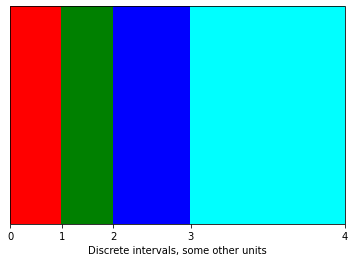

In [24]:
import matplotlib as mpl

fig, ax = plt.subplots(1, 1)

cmap = (mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan']))

bounds = [0, 2, 4, 7, 13]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax,
    boundaries=[0] + bounds + [13],  # Adding values for extensions.
    # extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal',
    label='Discrete intervals, some other units'
)
ax.set_xticklabels([0,1,2,3,4])
plt.show()

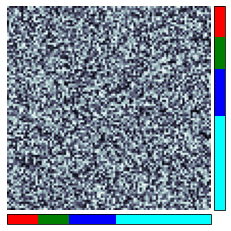

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = np.random.random((100, 100))

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax_right = divider.append_axes('right', size='5%', pad=0.05)
cax_bottom = divider.append_axes('bottom', size='5%', pad=0.05)

im = ax.imshow(data, cmap='bone')
ax.axis('off')

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax_right,
    boundaries=[0] + bounds + [13],  # Adding values for extensions.
    # extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='vertical',
    label='Discrete intervals, some other units'
)

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax_bottom,
    boundaries=[0] + bounds + [13],  # Adding values for extensions.
    # extend='both',
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal',
    label='Discrete intervals, some other units'
)
cax_right.axis('off')
cax_bottom.axis('off')
cax_right.invert_yaxis()
cax_bottom.invert_yaxis()
plt.show()